# IonQ Qiskit Provider Example

This notebook will walk you through a basic example of using an IonQ backend with Qiskit

## Setup

First, get an API token from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

Next, install the `qiskit-ionq-provider`: `pip install qiskit-ionq-provider`. If you're running this example notebook, you've likely already done this.

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

## Usage & Examples

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [2]:
# import packages
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ionq_provider import IonQProvider

provider = IonQProvider()

## Example — Bell Pair

Now, let's make a circuit for Bell pair, just to review some basic Qiskit syntax

In [22]:
# initialize the quantum circuit object with a quantum register length two and a classical register length two
gate = ("r", (0, 1, 2))

qc = QuantumCircuit(5,5)
getattr(qc, gate[0])(*gate[1])

# draw the circuit to make sure it's what we expect
qc.draw()

q_0: ──────────
               
q_1: ──────────
     ┌────────┐
q_2: ┤ R(0,1) ├
     └────────┘
q_3: ──────────
               
q_4: ──────────
               
c: 5/══════════

## Run on an IonQ Backend

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:

In [3]:
# view list of available backends
provider.backends()

[<IonQSimulatorBackend('ionq_simulator') from <qiskit_ionq_provider.ionq_provider.IonQProvider object at 0x1102d38e0>()>,
 <IonQQPUBackend('ionq_qpu') from <qiskit_ionq_provider.ionq_provider.IonQProvider object at 0x1102d38e0>()>]

In [4]:
# load backend by using the get_backend method
backend = provider.get_backend("ionq_simulator")

### Notes about running circuits on the IonQ backends
Circuit building and visualization should feel identical to building a circuit using any other backend in Qiskit. 

That said, there are a few things to note when running on IonQ backends: 
1. IonQ backends do not allow arbitrary unitaries, mid-circuit resets or measurements, or multi-experiment jobs. In practice, this means using `reset`, `initialize`, `u` `u1`, `u2`, `u3`, `cu`, `cu1`, `cu2`, or `cu3` gates will throw an exception on submission, as will measuring mid-circuit, and submmitting jobs with multiple experiments.
2. while `barrier` is allowed for organizational and visualization purposes, the IonQ compiler does not see it as a compiler directive.
3. For the unitaries (`u`, `u1`, etc) and some other custom gates that [include appropriate decompositions](https://qiskit.org/documentation/stubs/qiskit.circuit.Instruction.html#qiskit.circuit.Instruction.add_decomposition), you can use the `transpile` method to rewrite your circuit into basis gates that the IonQ backends will take. See the example below.

In [5]:
# transpilation example
from qiskit import transpile
from math import pi

t_qc = QuantumCircuit(1,1);
t_qc.u(pi/2, pi/4, pi, 0);
t_qc.measure(0,0)
transpiled = transpile(t_qc, backend)
print(transpiled)

global phase: 5π/8
     ┌──────────┐┌──────────┐┌─┐
q_0: ┤ RX(5π/4) ├┤ RY(-π/2) ├┤M├
     └──────────┘└──────────┘└╥┘
c: 1/═════════════════════════╩═
                              0 


### Running our bell pair circuit
Now, let's run our bell pair circuit on the simulator. 

Because we've already defined our backend and written our circuit, all we have to do now is `run` it:

In [6]:
# submit the circuit
job = backend.run(bell_qc)

In [7]:
# poll for the job's result   
result = job.result()

In [8]:
#get counts
counts = result.get_counts()
print(counts)

{'00': 0.4999999999999999, '11': 0.4999999999999999}


You can also use Qiskit's built-in tools to render the results as a histogram:

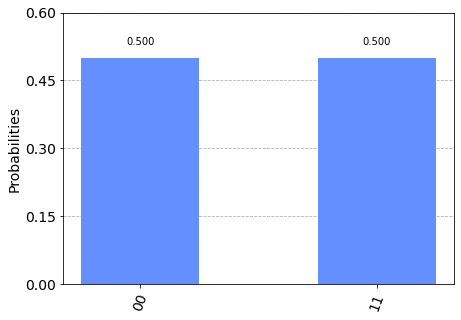

In [9]:
#visualize counts
plot_histogram(counts)

## Example - Bernstein-Vazirani


For our second example, let's build a Bernstein-Vazirani circuit and run it on a real IonQ quantum computer.

Rather than manually building the BV circuit every time, we'll create a method that can build one for any oracle $s$, and any register size.

In [10]:
def make_bv_circuit(s_int, input_size):
    """build the Bernstein-Vazirani circuit
     
    Args:
        s_int (int): value of s, the secret bitstring, as an integer
        input_size (int): size of the input register, 
            i.e. the number of (qu)bits to use for the binary 
            representation of s

    Returns:
        circ (obj): the completed BV circuit

    """
    # confirm the bitstring of S is what we think it should be
    s = ('{0:0' + str(input_size) + 'b}').format(s_int)
    print('s: ', s)
    
    # We need a circuit with `input_size` qubits, plus one ancilla qubit
    # Also need `input_size` classical bits to write the output to
    circ = QuantumCircuit(input_size + 1, input_size)

    # put ancilla in state |-⟩
    circ.h(input_size)
    circ.z(input_size)
    
    # Apply Hadamard gates before querying the oracle
    for i in range(input_size):
        circ.h(i)

    # Apply the inner-product oracle
    s = s[::-1] # reverse s to fit qiskit's qubit ordering
    for q in range(input_size):
        if s[q] == '1':
            circ.cx(q, input_size)

    # Apply Hadamard gates after querying the oracle
    for i in range(input_size):
        circ.h(i)

    # Measurement
    for i in range(input_size):
        circ.measure(i, i)
    
    return circ 

Now let's use that method to create a BV circuit to submit:

In [11]:
# Make a BV circuit:
s_int = 3
input_size = 3
bv_qc = make_bv_circuit(s_int, input_size)

# Print the circuit to confirm it was built as expected
bv_qc.draw()

s:  011


┌───┐          ┌───┐          ┌─┐   
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───
     ├───┤       │  └───┘     ┌───┐└╥┘┌─┐
q_1: ┤ H ├───────┼─────────■──┤ H ├─╫─┤M├
     ├───┤┌───┐  │   ┌─┐   │  └───┘ ║ └╥┘
q_2: ┤ H ├┤ H ├──┼───┤M├───┼────────╫──╫─
     ├───┤├───┤┌─┴─┐ └╥┘ ┌─┴─┐      ║  ║ 
q_3: ┤ H ├┤ Z ├┤ X ├──╫──┤ X ├──────╫──╫─
     └───┘└───┘└───┘  ║  └───┘      ║  ║ 
c: 3/═════════════════╩═════════════╩══╩═
                      2             0  1

Time to run it on an IonQ QPU!

In [12]:
# Get the IonQ QPU backend to run circuits on:
qpu_backend = provider.get_backend("ionq_qpu")

# Then run the circuit:
bv_job = qpu_backend.run(bv_qc)

As QPU time is a limited resource, QPU jobs are handled in a queue, and may take a little bit of time to return. Let's set up a cell we can run every once and a while that will print the status if it's not done, and the results if it is (you could also have this run on a loop with e.g. a minute or two sleep between checks) 

In [15]:
from qiskit.providers.jobstatus import JobStatus

# Check if job is done
if bv_job.status() is JobStatus.DONE:
    
    print("Job status is DONE")
    
    # Fetch the result:
    bv_job_result = bv_job.result()
   
else:
    print("Job status is ", bv_job.status() )

Job status is DONE


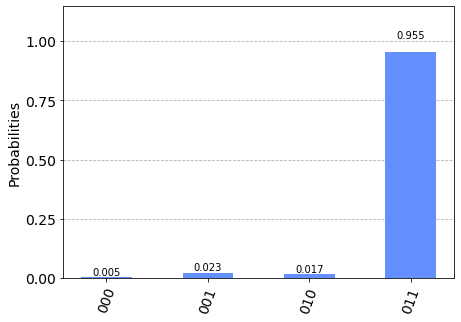

In [16]:
# If Job is finished, plot and validate results 
# (this cell will throw if we don't have results yet)
plot_histogram(bv_job_result.get_counts())

## Job History

Provider backends can also be used to retrieve previously run jobs:

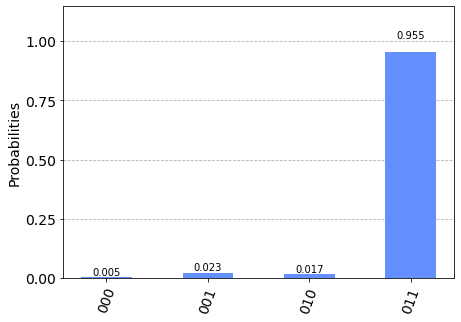

In [17]:
# Retrieve with job id. You can get this from a submitted job with the job_id() method.
job_id = bv_job.job_id()
retrieved = backend.retrieve_job(job_id) 
counts = retrieved.result().get_counts()
plot_histogram(counts)